Preprocessing func and mfcc extraction

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
sample time: 16.00 ms


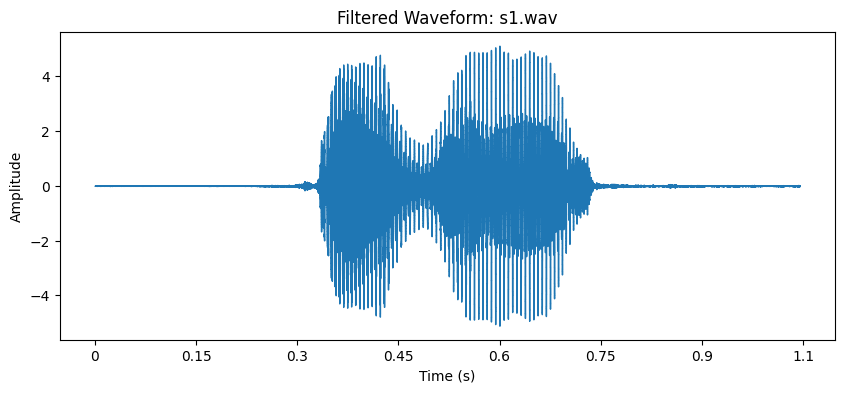

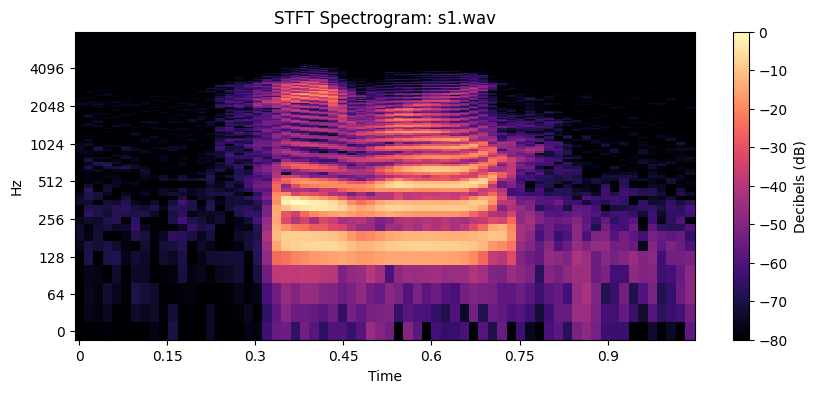

/usr/local/lib/python3.11/dist-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


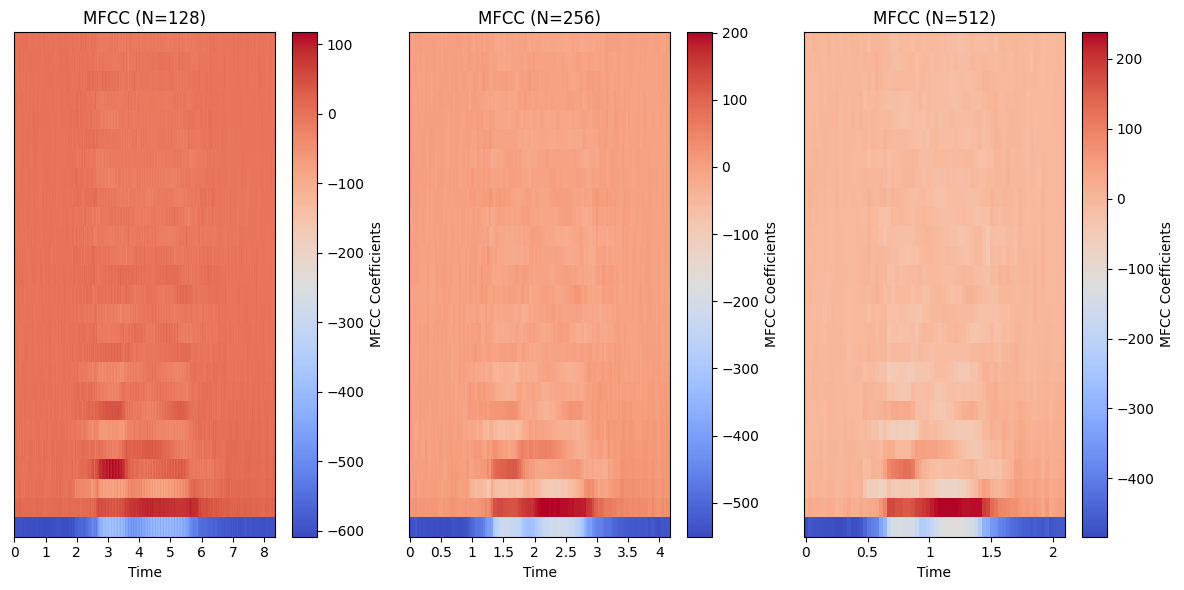

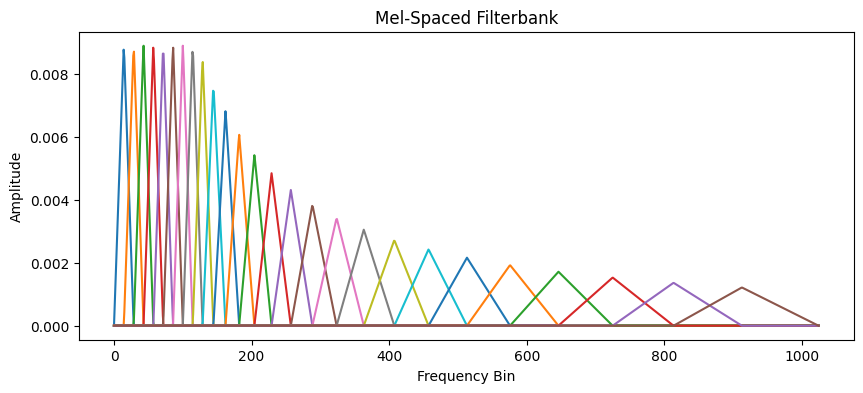

sample time: 16.00 ms


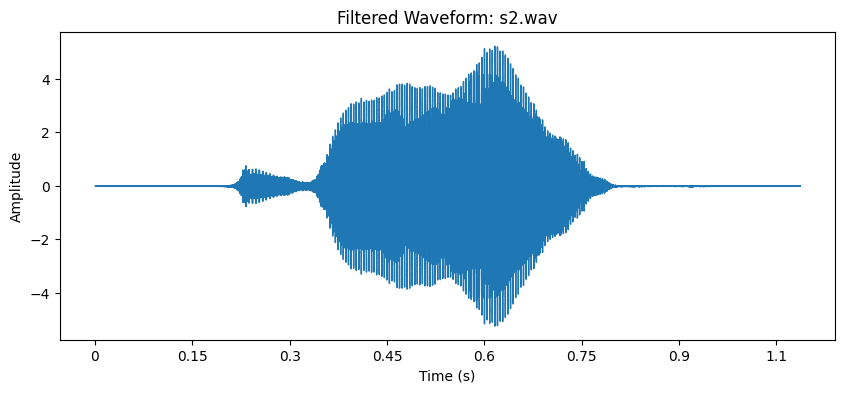

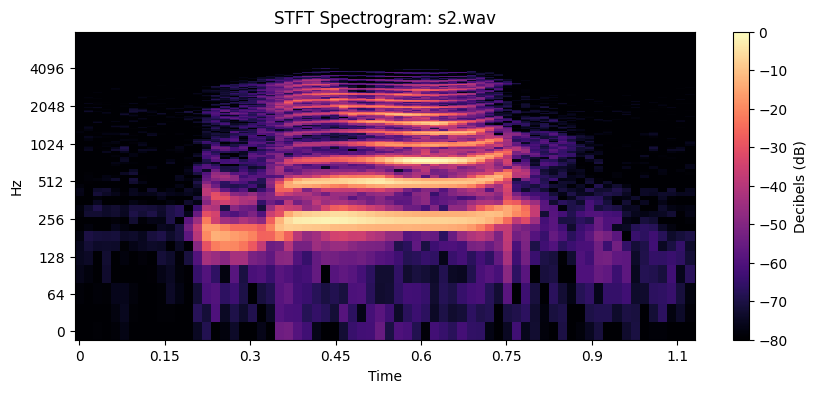

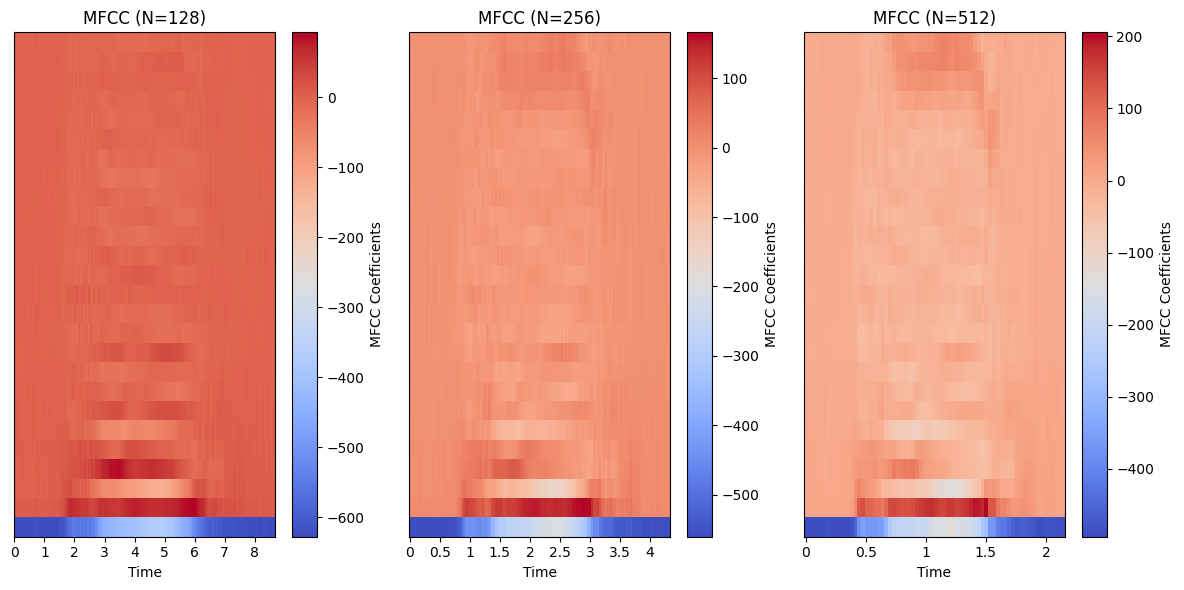

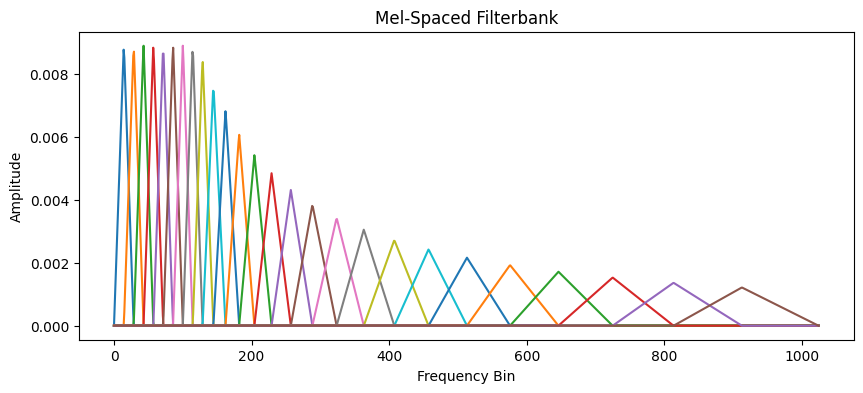

sample time: 16.00 ms


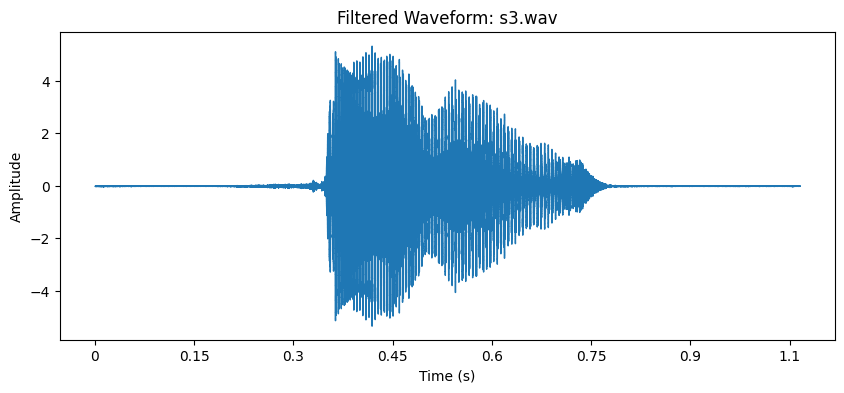

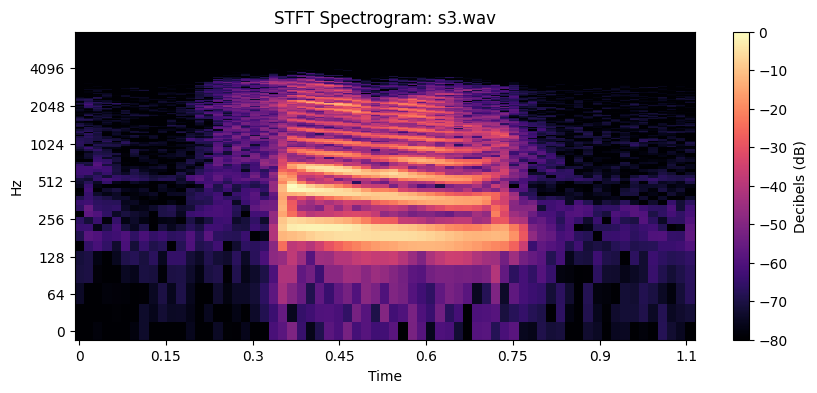

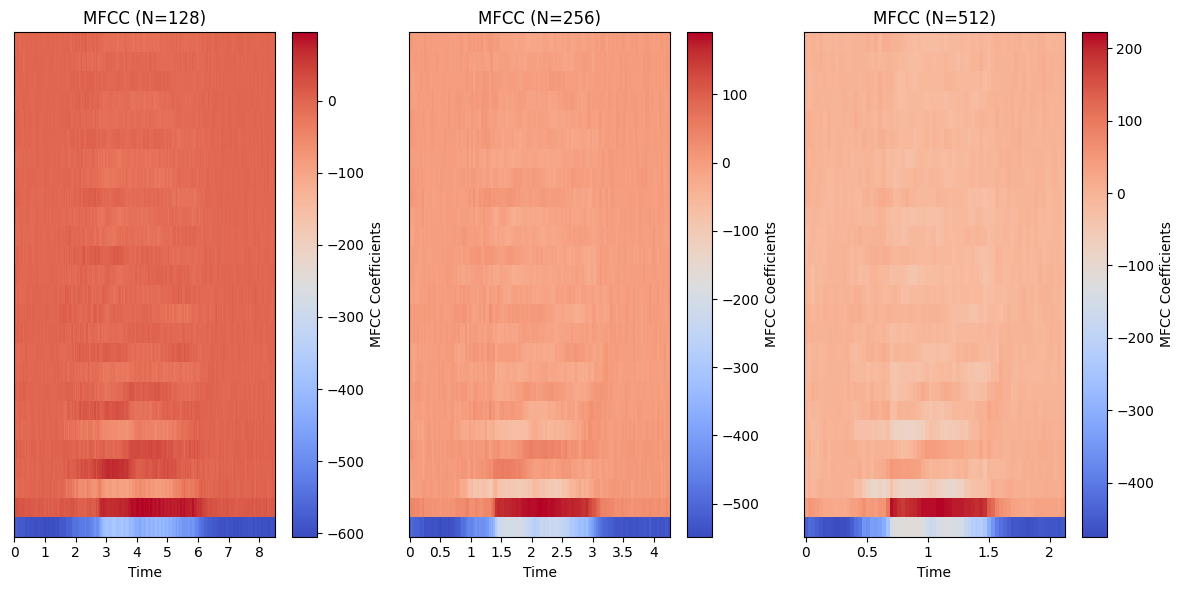

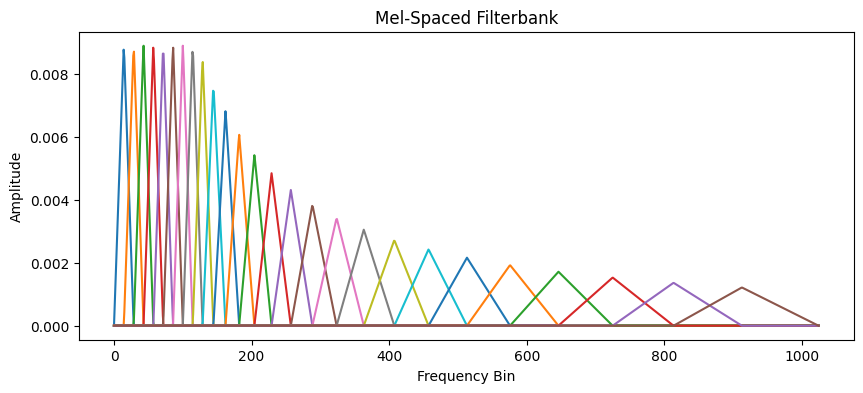

sample time: 16.00 ms


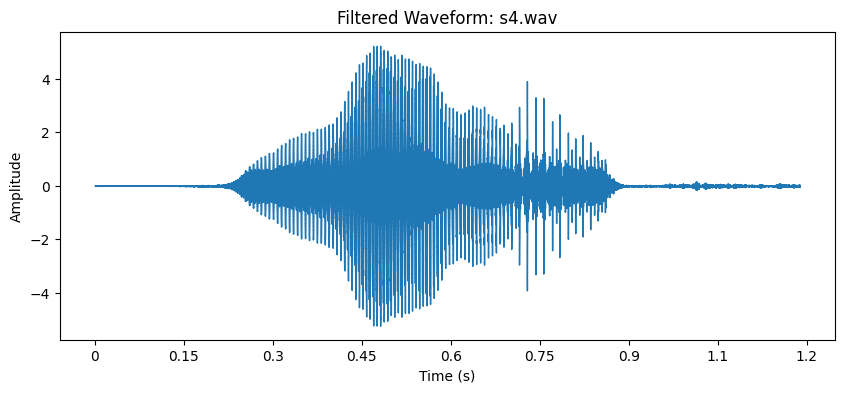

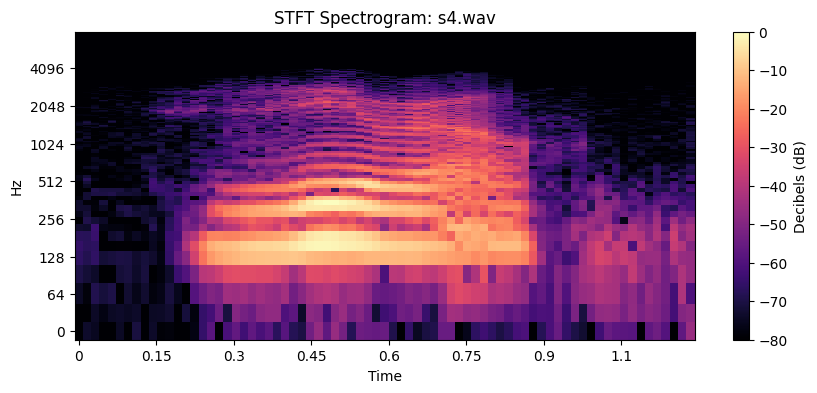

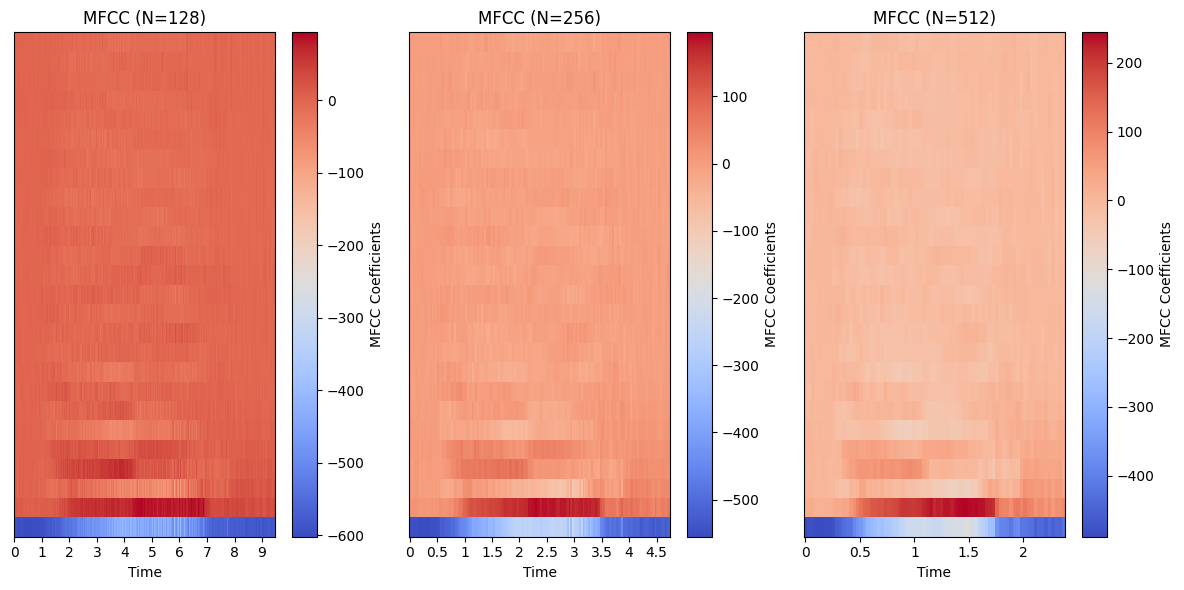

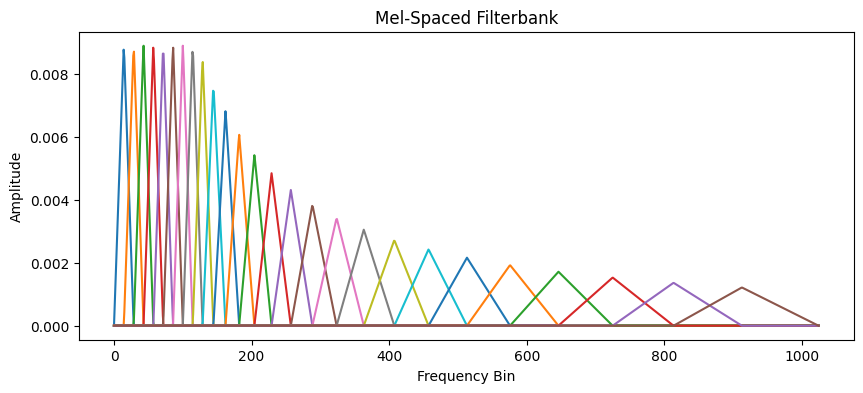

sample time: 16.00 ms


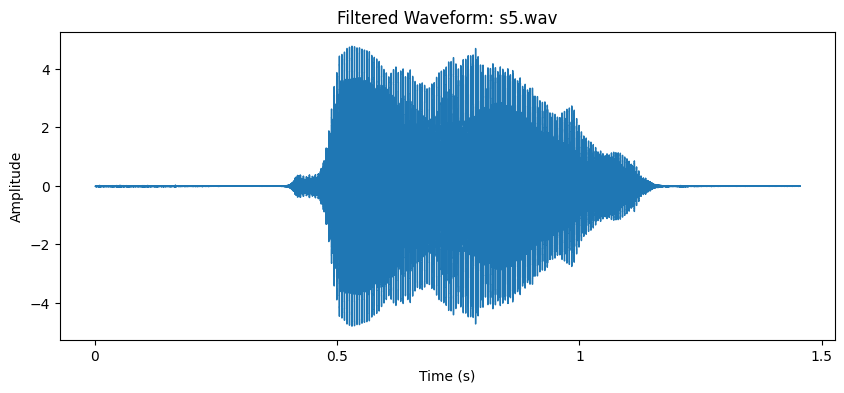

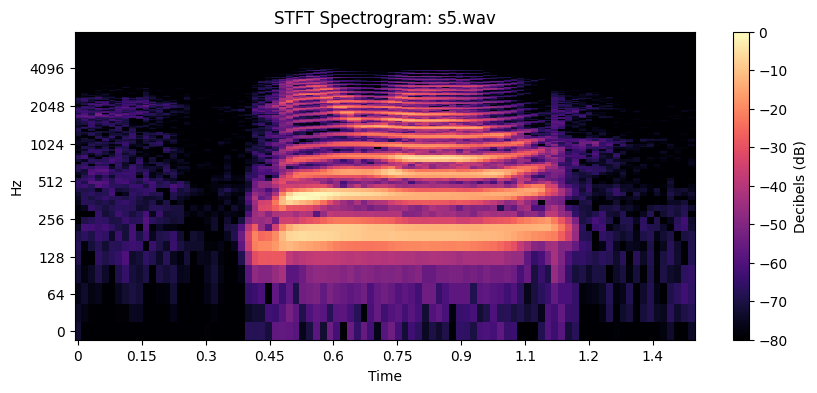

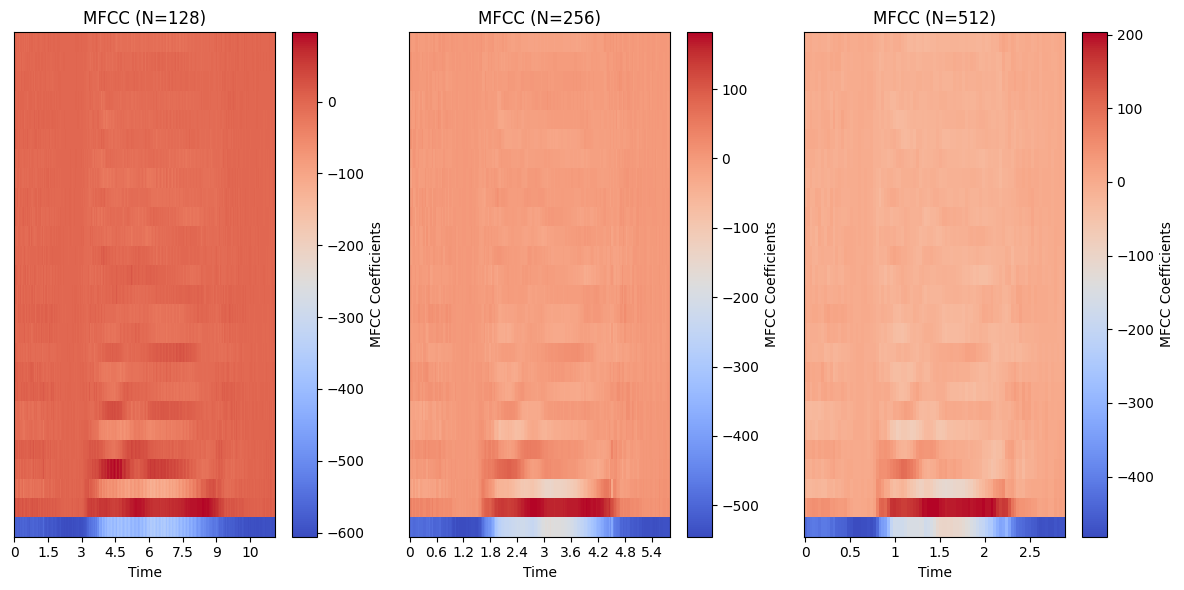

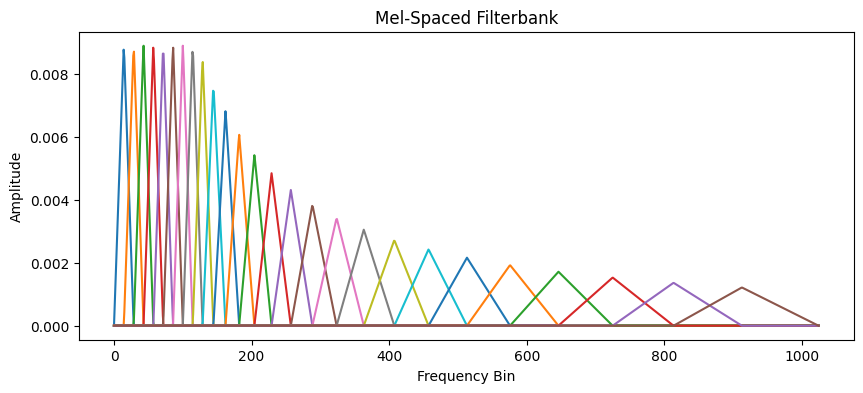

sample time: 16.00 ms


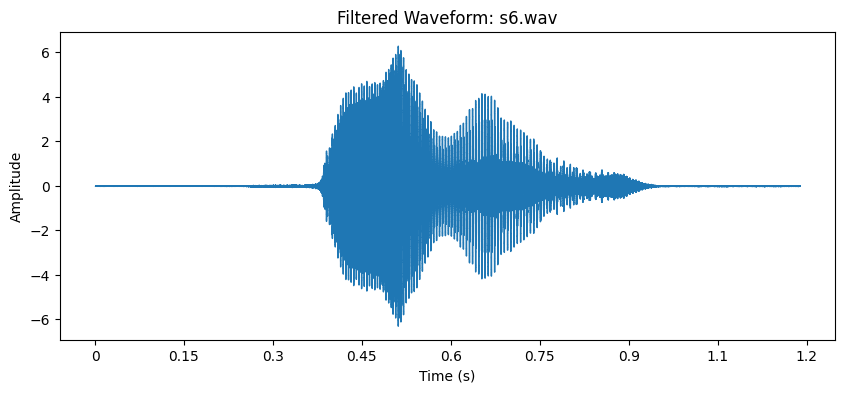

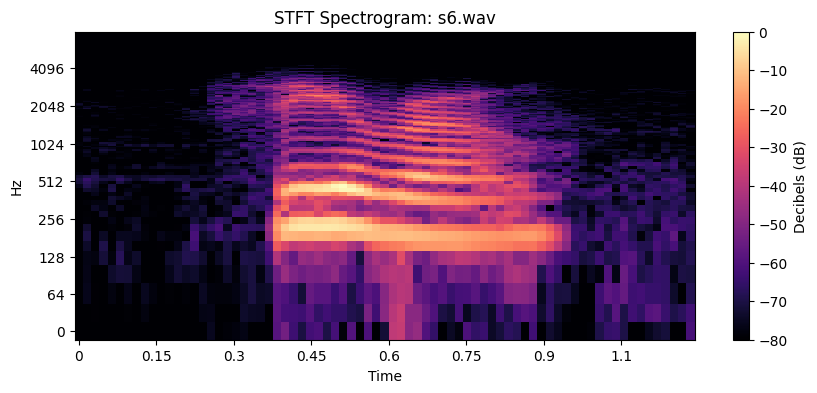

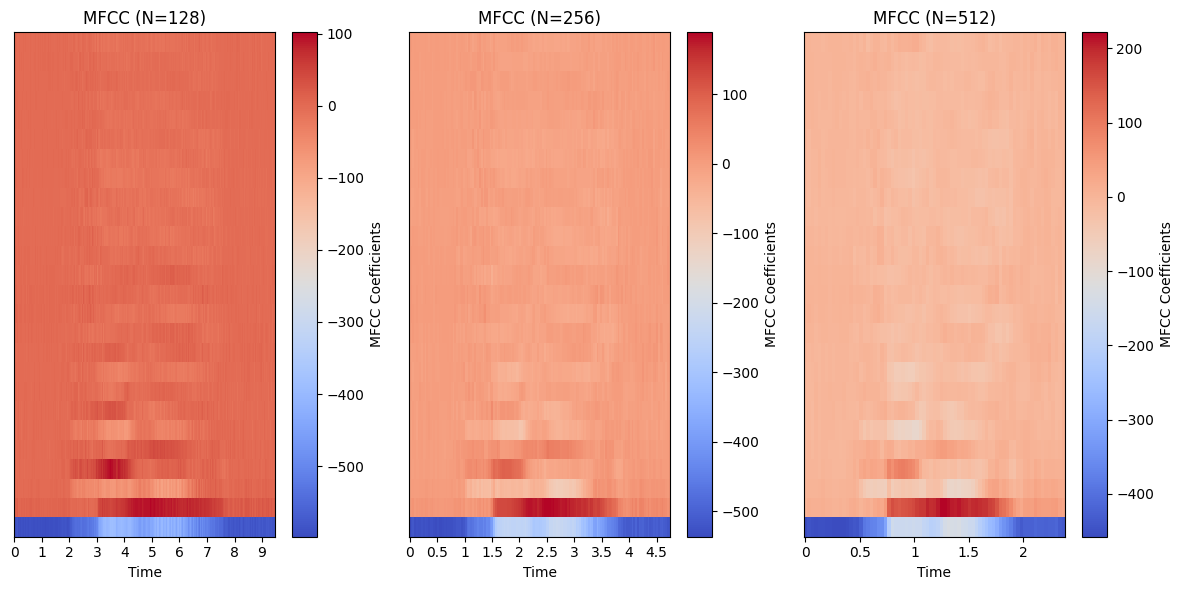

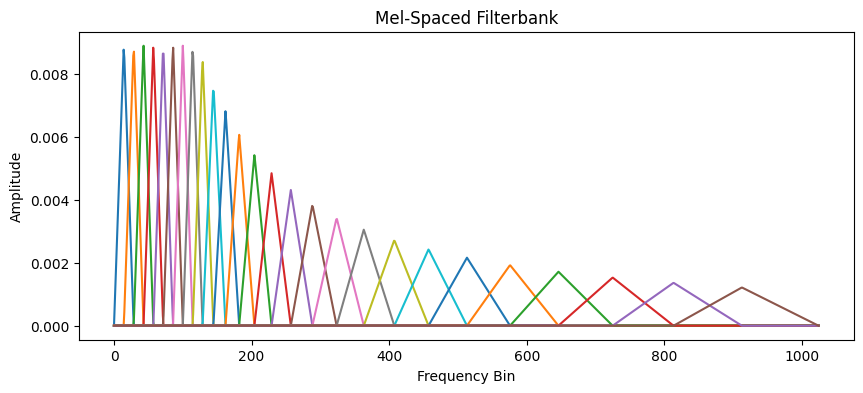

sample time: 16.00 ms


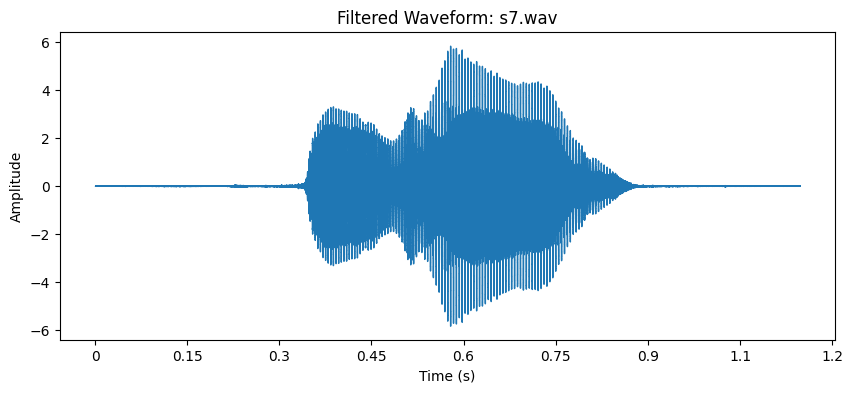

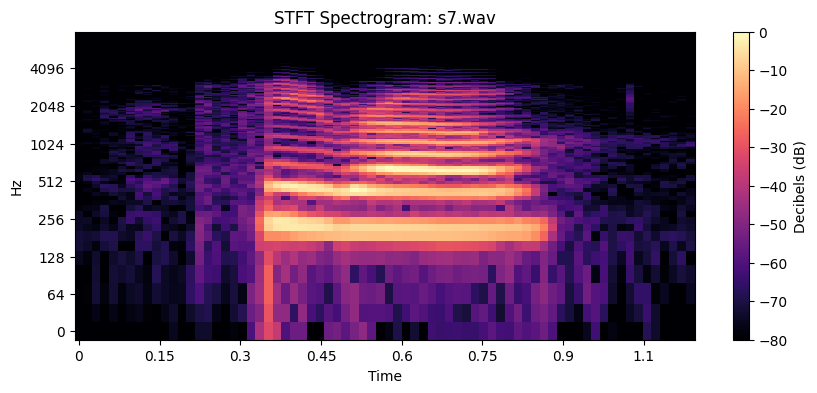

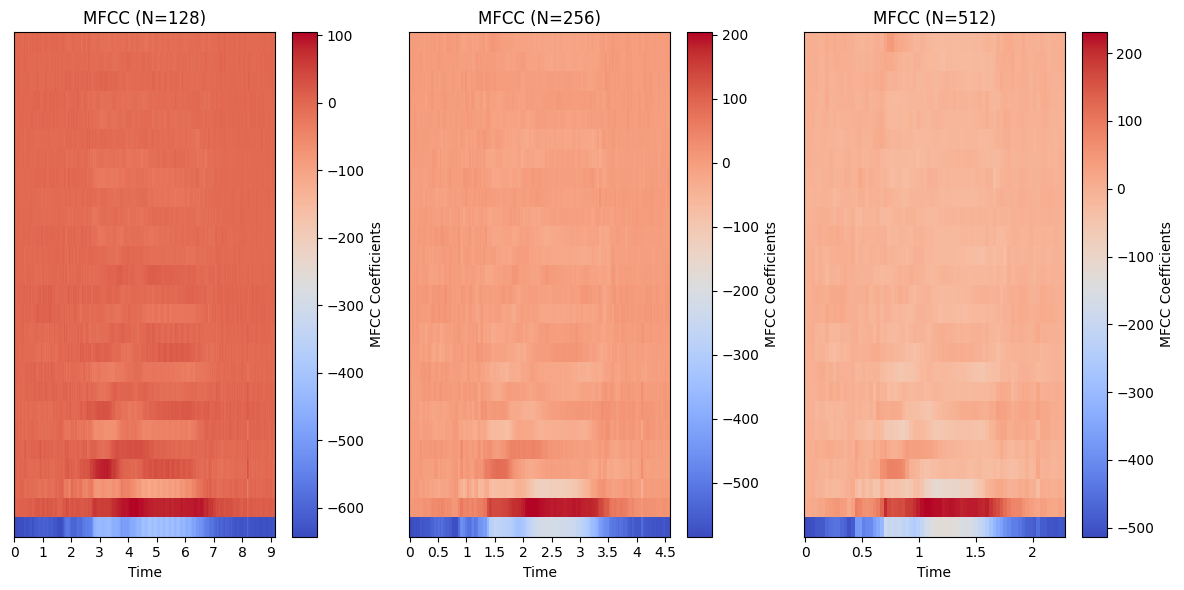

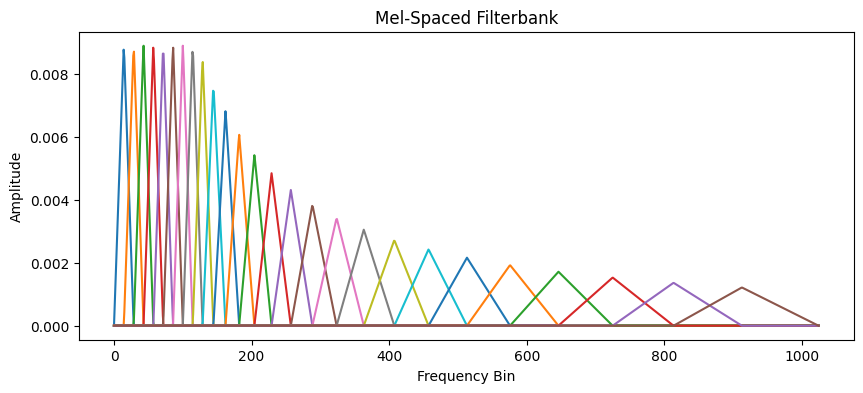

sample time: 16.00 ms


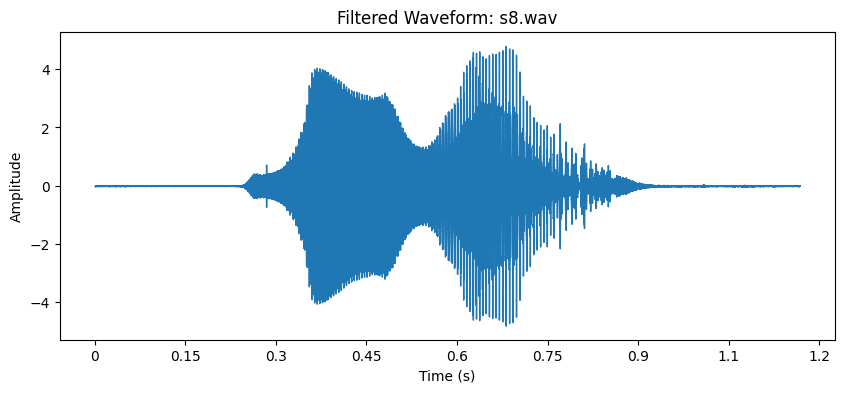

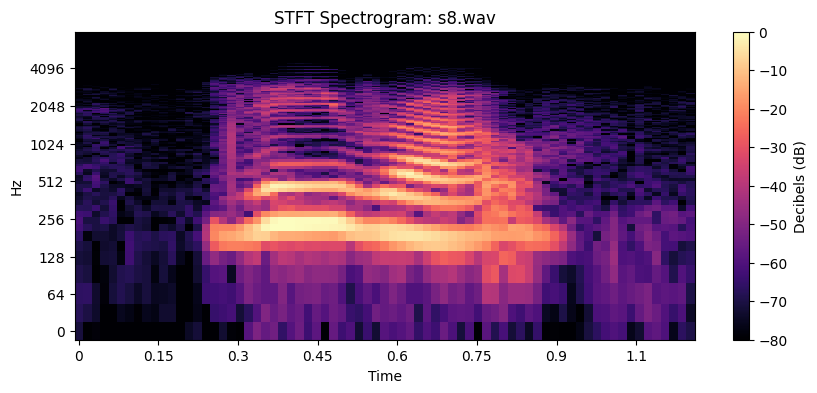

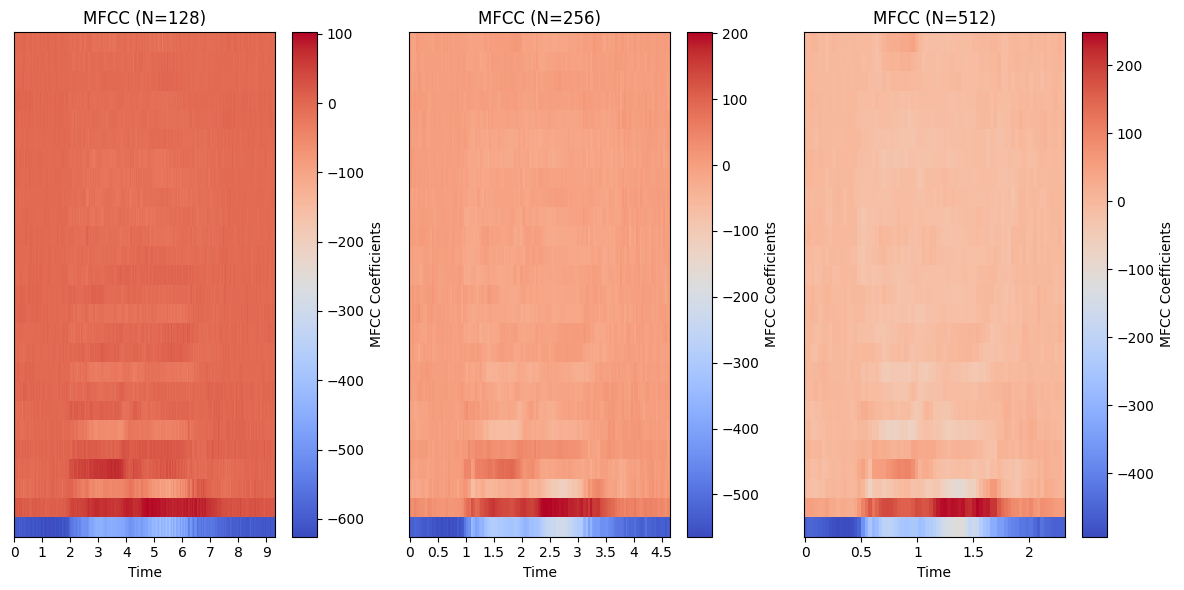

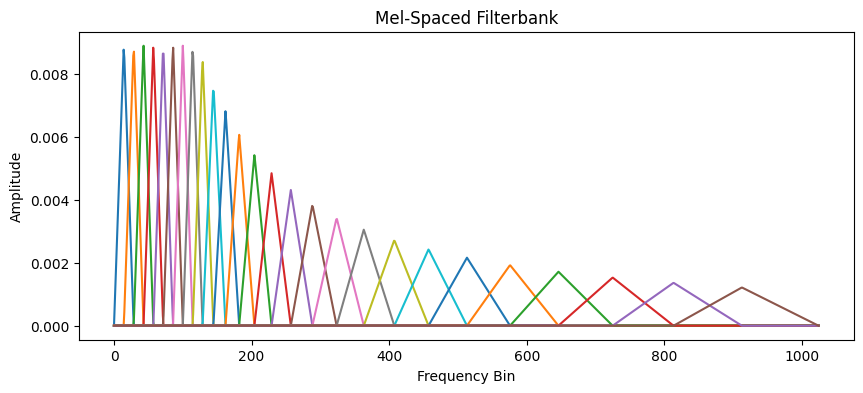

sample time: 16.00 ms


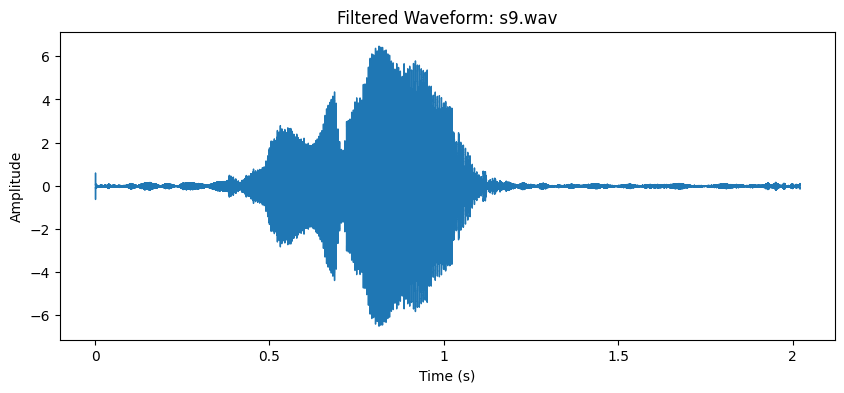

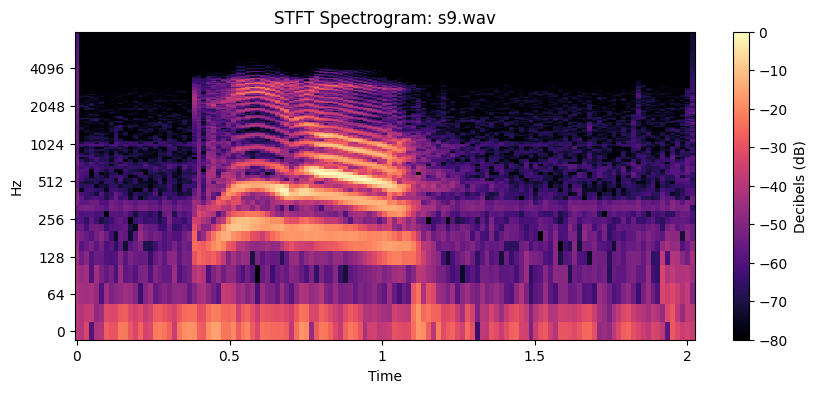

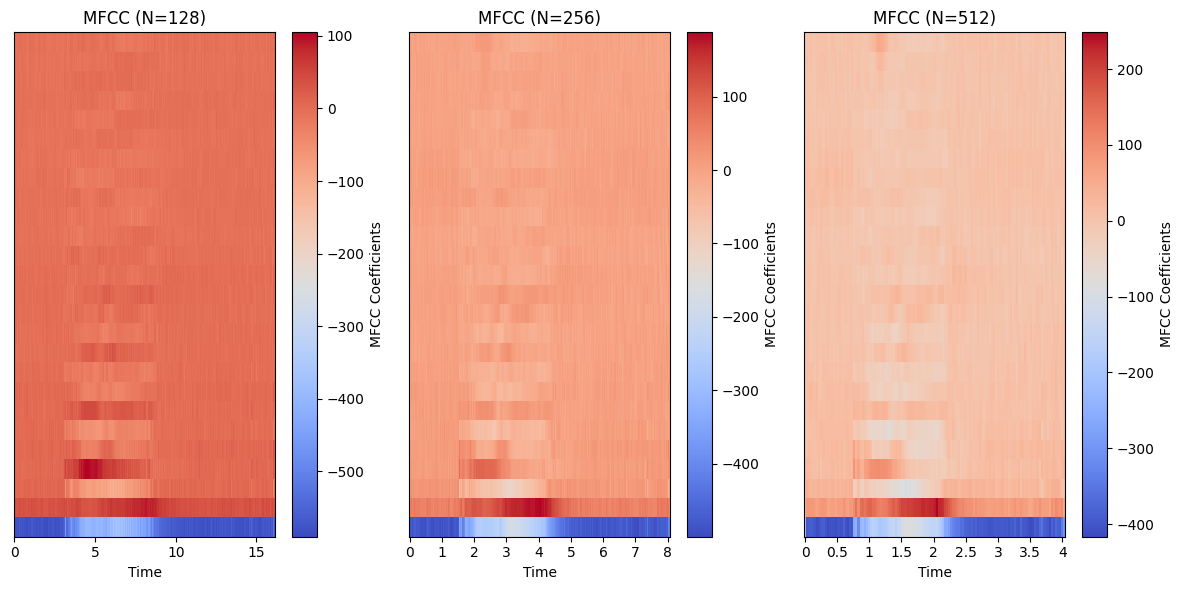

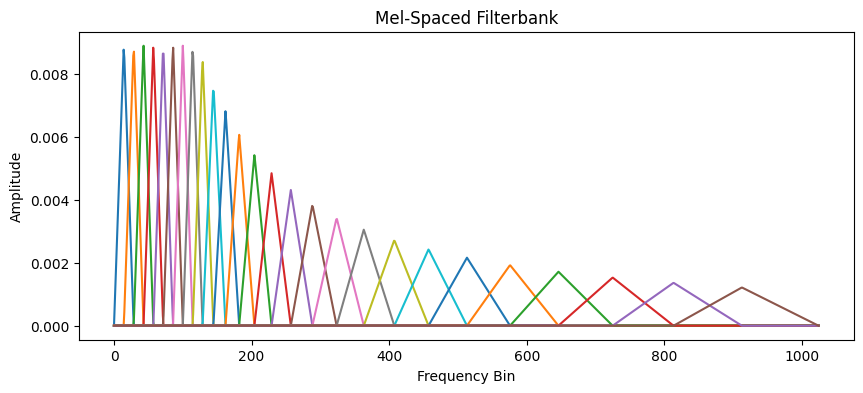

sample time: 16.00 ms


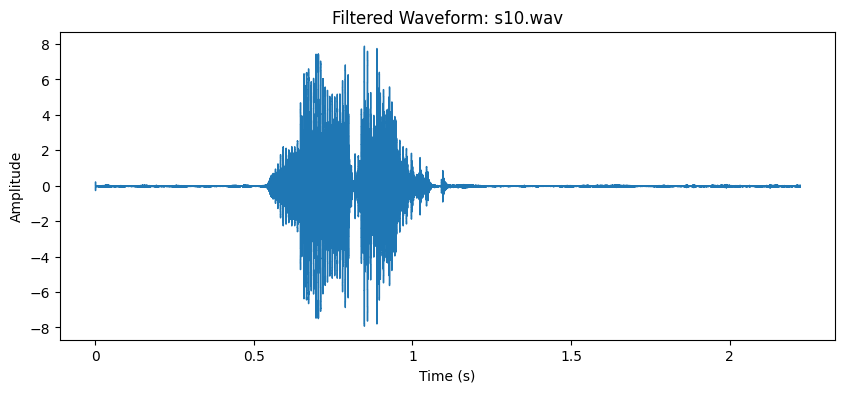

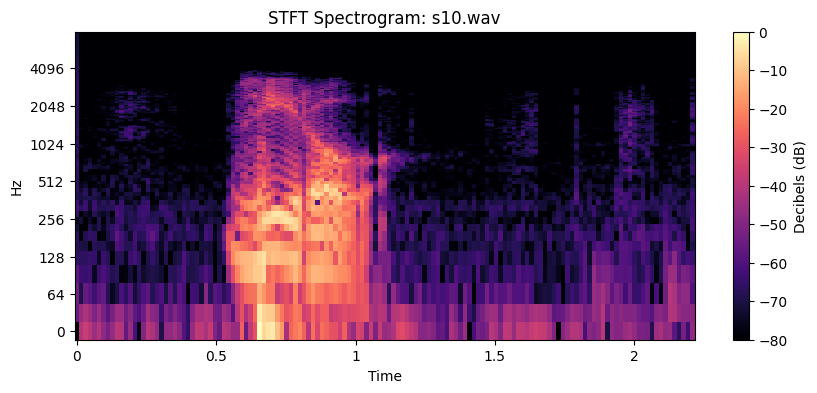

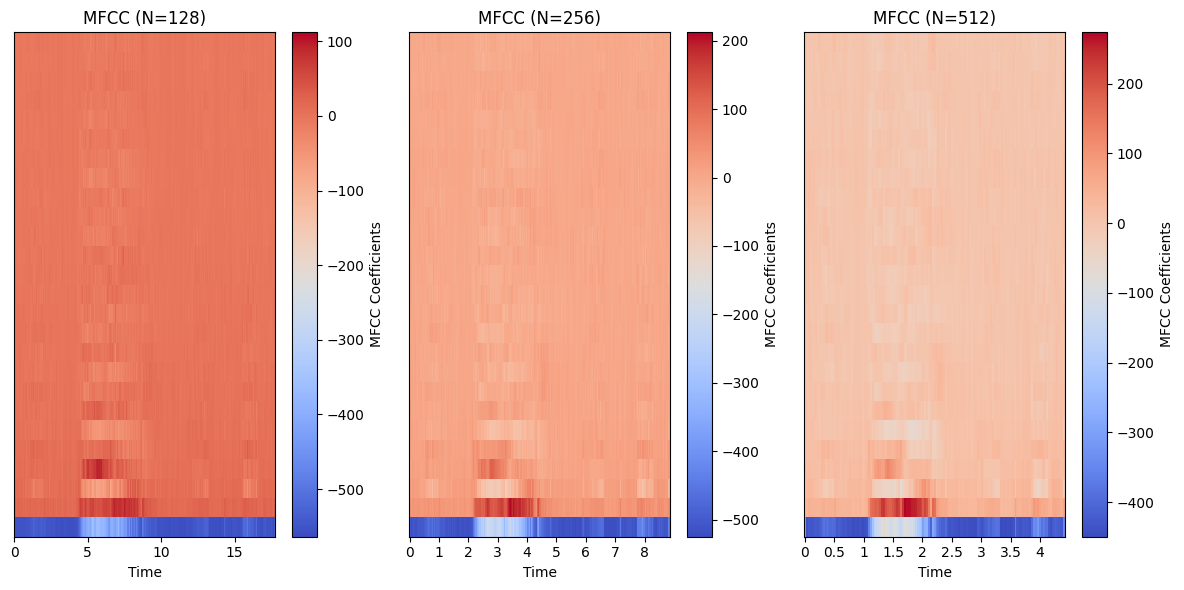

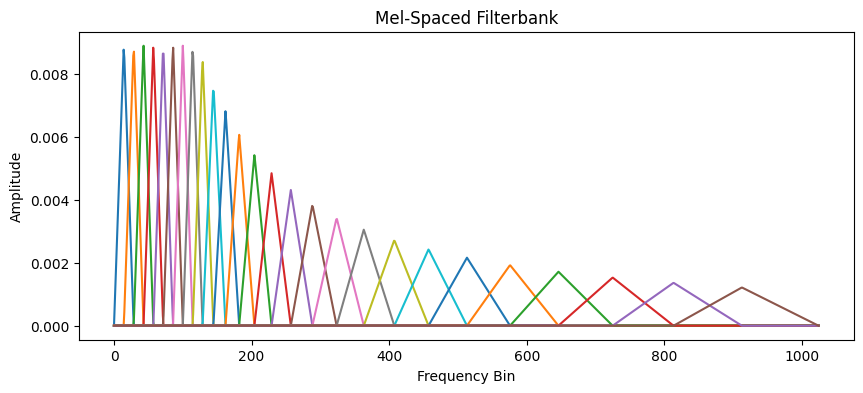

sample time: 16.00 ms


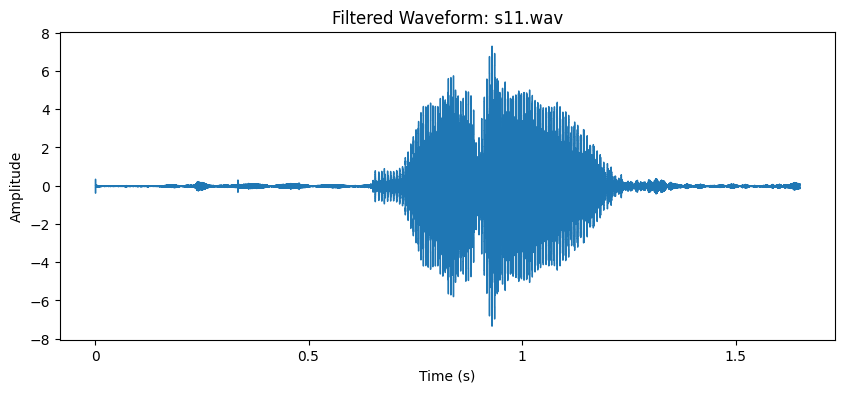

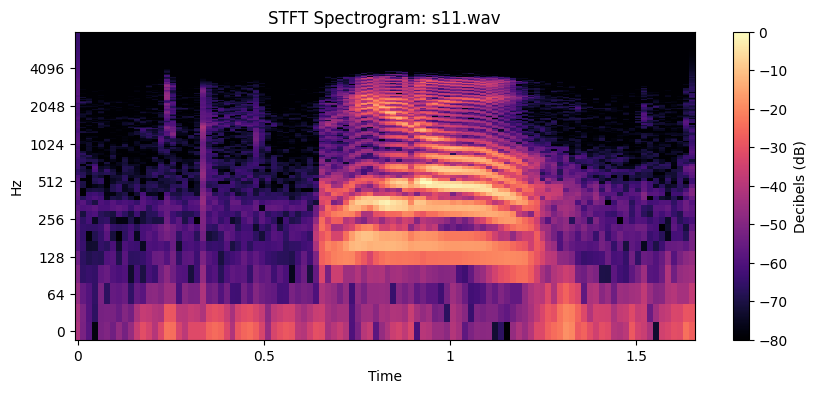

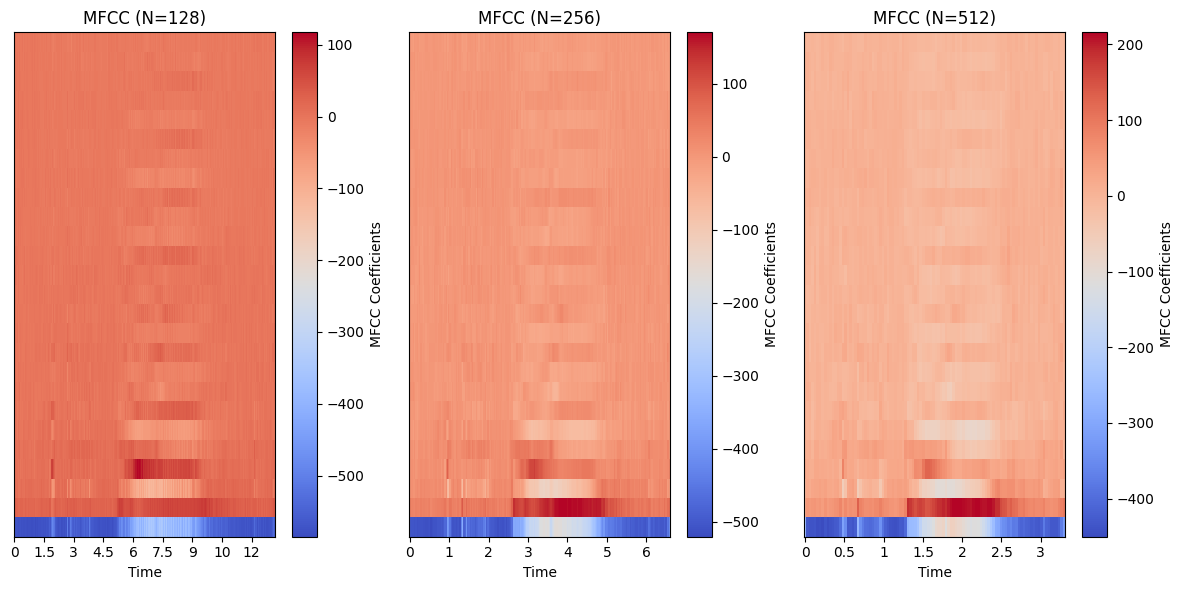

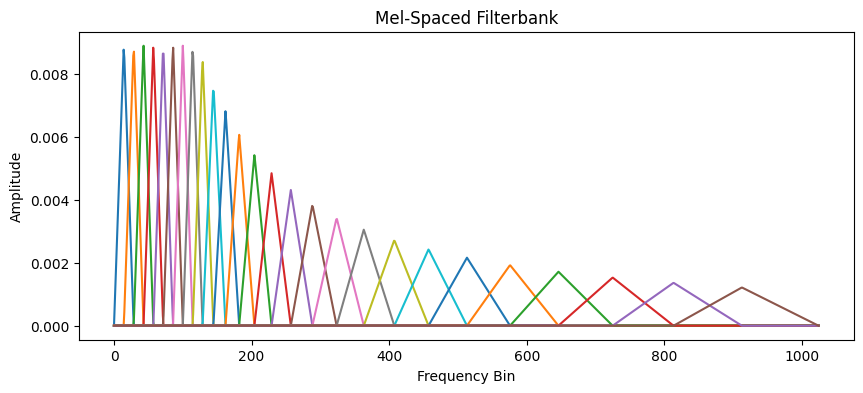

In [131]:
from google.colab import drive
drive.mount('/content/drive')
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

# Path link
DRIVE_PATH = "/content/drive/MyDrive/GivenSpeech_Data/Training_Data"
audio_files = ["s1.wav", "s2.wav", "s3.wav","s4.wav","s5.wav","s6.wav","s7.wav","s8.wav","s9.wav","s10.wav","s11.wav"]

mfcc_features = []
labels = []

def load_audio(file_name, sr=16000):
    file_path = os.path.join(DRIVE_PATH, file_name)
    signal, sample_rate = librosa.load(file_path, sr=sr)
    return signal, sample_rate # np.ndarray, int

def normalize_audio(signal):
    return (signal - np.mean(signal)) / np.std(signal) # np.ndarray

def lowpass_filter(signal, sr, cutoff=3000, order=5):
    nyquist = 0.5 * sr
    normal_cutoff = cutoff / nyquist
    b, a = scipy.signal.butter(order, normal_cutoff, btype='low', analog=False)
    filtered_signal = scipy.signal.filtfilt(b, a, signal)
    return filtered_signal # np.ndarray

def compute_sample_time(sr, N=256):
    time_ms = (N / sr) * 1000
    print(f"sample time: {time_ms:.2f} ms")

def compute_mfcc(signal, sr, n_mfcc=26, n_fft=1024, hop_length=256):
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    # mfccs = (mfccs - np.mean(mfccs, axis=1, keepdims=True)) / np.std(mfccs, axis=1, keepdims=True)
    return mfccs # np.ndarray

def plot_waveform(signal, sr, title="Waveform"):
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(signal, sr=sr)
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()


def plot_stft(signal, sr, n_fft=512, hop_length=256, title="STFT Spectrogram"):
    D = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)
    D_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(D_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
    plt.colorbar(label="Decibels (dB)")
    plt.title(title)
    plt.show()

# Different window sizes mfcc
def compare_mfcc(signal, sr):
    n_fft_values = [128, 256, 512]
    plt.figure(figsize=(12, 6))
    for i, n_fft in enumerate(n_fft_values):
        mfccs = compute_mfcc(signal, sr, n_mfcc=26, n_fft=n_fft, hop_length=n_fft//2)
        plt.subplot(1, 3, i+1)
        librosa.display.specshow(mfccs, sr=sr, x_axis='time')
        plt.colorbar(label="MFCC Coefficients")
        plt.title(f"MFCC (N={n_fft})")
    plt.tight_layout()
    plt.show()

def plot_mel_filterbank(sr=16000, n_fft=256, n_mels=26):
    mel_filters = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)
    plt.figure(figsize=(10, 4))
    for i in range(mel_filters.shape[0]):
        plt.plot(mel_filters[i], label=f"Mel {i+1}")
    plt.title("Mel-Spaced Filterbank")
    plt.xlabel("Frequency Bin")
    plt.ylabel("Amplitude")
    plt.show()

# Preprocess function
# Return value: filtered_signal and mfcc_matrix
def process_audio(file_name, speaker_id):
    signal, sr = load_audio(file_name)
    normalized_signal = normalize_audio(signal)
    filtered_signal = lowpass_filter(normalized_signal, sr)
    mfccs = compute_mfcc(filtered_signal, sr)

    compute_sample_time(sr)
    plot_waveform(filtered_signal, sr, title=f"Filtered Waveform: {file_name}")
    plot_stft(filtered_signal, sr, title=f"STFT Spectrogram: {file_name}")
    compare_mfcc(filtered_signal, sr)
    plot_mel_filterbank(sr, n_fft=2048, n_mels=26)

    mfcc_features.append(mfccs.T)
    labels.append(np.full(mfccs.shape[1], speaker_id))
    return filtered_signal, mfccs

for i, file in enumerate(audio_files):
    process_audio(file, speaker_id=i+1)




> Vector Quantization



In [132]:
print(len(labels))

11


In [142]:
from scipy.cluster.vq import kmeans, vq

def normalize_mfcc(mfcc_features):
    mfcc_features = np.vstack(mfcc_features)
    mean = np.mean(mfcc_features, axis=0)
    std = np.std(mfcc_features, axis=0)
    return (mfcc_features - mean) / std

def lbg_algorithm(features, num_clusters=16, epsilon=0.01):
    codebook, _ = kmeans(features, 1)
    while codebook.shape[0] < num_clusters:
        new_codebook = np.vstack([codebook * (1 + epsilon), codebook * (1 - epsilon)])
        new_codebook, _ = kmeans(features, new_codebook.shape[0])
        codebook = new_codebook
    return codebook

def train_vq_codebook(mfcc_features, num_clusters_person=16):
    mfcc_features = np.vstack(mfcc_features)
    num_speakers = len(labels) # activately adjust num_clusters with num_speakers
    total_clusters = num_clusters_person * num_speakers
    codebook = lbg_algorithm(mfcc_features, total_clusters)
    return codebook

mfcc_features = normalize_mfcc(mfcc_features)
vq_codebook = train_vq_codebook(mfcc_features, num_clusters_person=16)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


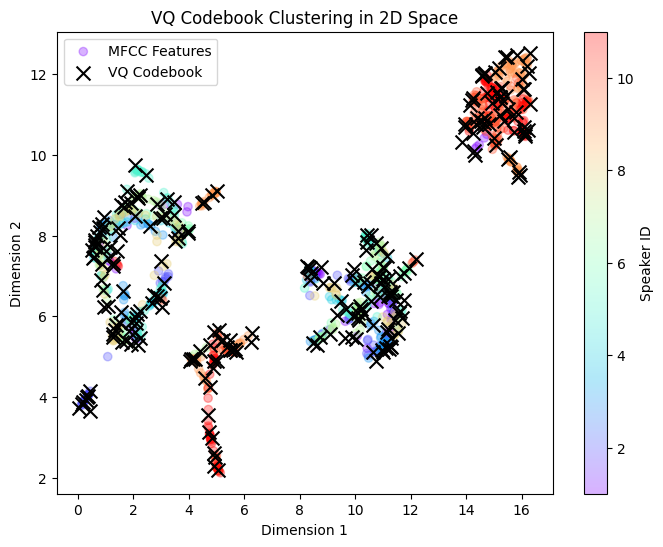

In [143]:
import umap

def plot_vq_codebook_umap(mfcc_features, labels, codebooks):
    mfcc_features = np.vstack(mfcc_features)
    labels = np.concatenate(labels)

    reducer = umap.UMAP(n_components=2, n_neighbors=20, min_dist=0.05, metric='euclidean')
    reduced_mfcc = reducer.fit_transform(mfcc_features)
    reduced_codebooks = reducer.transform(codebooks)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced_mfcc[:, 0], reduced_mfcc[:, 1], c=labels, cmap='rainbow', alpha=0.3, label="MFCC Features")
    plt.scatter(reduced_codebooks[:, 0], reduced_codebooks[:, 1], c='black', marker='x', s=100, label="VQ Codebook")

    plt.colorbar(scatter, label="Speaker ID")
    plt.title("VQ Codebook Clustering in 2D Space")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.legend()
    plt.show()

plot_vq_codebook_umap(mfcc_features, labels, vq_codebook)
